<div style="font-weight: bold; font-size: x-large; color: blue">***Setup***</div>

In [1]:
import os
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats.mstats import winsorize

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', '{:.2f}'.format)

dataset_type = 'Winsorized'

##Run in the background
##Create
#tmux new -s jn

##Run
#papermill "3. Predictive modeling (Orginal data).ipynb" output.ipynb

##Deattach
#Ctrl-b, d 

##Attach
#tmux a -t jn

In [2]:
#Functions
#Winsorizing at 1% tails by default
def winsorize_columns(df, columns, limits = (0.01, 0.01)): 
    #Vars
    df_winsorized = df.copy()

    #Iterate
    for col in columns:
        df_winsorized[col] = winsorize(df_winsorized[col], limits = limits, nan_policy = 'raise')

    #Return
    return df_winsorized
    
def loadOrTrainModel(X_train, y_train, X_test, y_test, model_file_name, model_type, default_model_params, save_model = True):
    #Load existing model (If it exists)
    model, features, training_cv_score = loadModel(model_file_name)
    
    #Train if null
    if model is None:
        #Train
        training_cv_score, features = trainModel(X_train, y_train, model_type, default_model_params)

        #Fit
        model = getModel(model_type, default_model_params)
        model.fit(X_train[features], y_train)
        
        #Save model
        if save_model is True:
            saveModel(model_file_name, model, features, training_cv_score)
        
    #Evaluate
    print(f"Best features: {", ".join(features)}.\n")
  
    evalModel(X_train[features], y_train, X_test[features], y_test, model, training_cv_score)

    #Return
    return model, features, training_cv_score
    
def trainModel(X_train, y_train, model_type, default_model_params):
    #Apply RFECV for feature selection
    rfecv = RFECV(
        estimator = getModel(model_type, default_model_params),
        cv = 10,
        scoring = 'neg_mean_squared_error',
        n_jobs = -1
    )
    
    rfecv.fit(X_train, y_train)

    #Mean CV score
    mean_cv_scores = rfecv.cv_results_['mean_test_score']

    #Best mean CV score across all feature subsets
    training_cv_score = np.max(mean_cv_scores)

    #Convert to RMSE
    training_cv_rmse_score = np.sqrt(abs(training_cv_score))
    
    #Selected features
    temp = rfecv.support_
    best_features = X_train.columns[temp]

    #Return
    return training_cv_rmse_score, best_features

#Use test set to evaluate models, but don't tune hyperparameters based on test performance to avoid leaking information from the test set into the model selection process.
def tuneModel(X_train, y_train, X_test, y_test, model_file_name, model_type, param_grid):
    if not os.path.exists('Models/' + model_file_name + ".pickle"):
        #Vars
        rmse_scorer = make_scorer(root_mean_squared_error, greater_is_better = False)
        
        #Grid search
        grid_search = GridSearchCV(getModel(model_type, {}), param_grid, scoring = rmse_scorer, cv = 10, error_score = 'raise', n_jobs = -1, verbose = 1)
        grid_search.fit(X_train, y_train)
    
        #Get best model
        best_model = grid_search.best_estimator_
    
        #Get best params
        best_model_params = grid_search.best_params_
    
        #Get best mean CV score
        #Setting greater_is_better=False negates RMSE, making lower RMSE correspond to a higher score, so grid_search.best_score_ is negative.
        best_training_cv_score = -grid_search.best_score_
    
        #Evaluate
        evalModel(X_train, y_train, X_test, y_test, best_model, best_training_cv_score)
    
        #Print
        print(" ")
        print(f"Best parameters: {best_model_params}.")
        
        #Return
        return best_model, best_model_params, best_training_cv_score

    else:
        return None, None, None
    
def evalModel(X_train, y_train, X_test, y_test, model, training_cv_score):
    ##Training
    #Vars
    predictions = model.predict(X_train)

    #RMSE
    training_rmse = root_mean_squared_error(y_train, predictions) 

    #Adjusted R2
    #Total number of observations
    n_samples = len(y_train) 

    #Number of predictors
    n_features = X_train.shape[1] 

    #R2
    r2 = r2_score(y_train, predictions)
    
    training_adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)


    
    ##Test
    test_predictions = model.predict(X_test)

    #RMSE
    test_rmse = root_mean_squared_error(y_test, test_predictions) 

    #Adjusted R2
    #Total number of observations
    n_samples = len(y_test) 

    #Number of predictors
    n_features = X_test.shape[1] 

    #R2
    r2 = r2_score(y_test, test_predictions)
    
    test_adj_r2 = 1 - (1 - r2) * (n_samples - 1) / (n_samples - n_features - 1)
    

    
    ##Print
    print(f"Training CV RMSE: {training_cv_score}.")
    print(f"Training RMSE: {training_rmse}.")
    print(f"Training Adjusted R2: {training_adj_r2}.")   
    print(" ")

    print(f"Test RMSE: {test_rmse}.")
    print(f"Test Adjusted R2: {test_adj_r2}.")    
    print(" ")



    ##Predicted vs actual
    model_name = type(model).__name__
    
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, test_predictions, alpha = 0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw = 2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs. Predicted Values for the Test Dataset (' + model_name + ')')
    plt.savefig('Graphs/Predicted vs Actual - ' + dataset_type + ' (' + model_name + ').png')
    plt.show()
    
def saveModel(model_file_Name, model, features, training_cv_score):
    #Save the trained model
    with open('Models/' + model_file_Name + ".pickle", "wb") as file:
        pickle.dump(model, file)  

    #Save best features
    with open('Models/' + model_file_Name + ".features", "wb") as file:
        pickle.dump(features, file)

    #Save training CV score
    with open('Models/' + model_file_Name + ".cv_score", "wb") as file:
        pickle.dump(training_cv_score, file)
    
def loadModel(model_file_Name):
    if os.path.exists('Models/' + model_file_Name + ".pickle") and os.path.exists('Models/' + model_file_Name + ".features") and os.path.exists('Models/' + model_file_Name + ".cv_score"):
        #Vars
        model = None
        features = None

        #Load model
        with open('Models/' + model_file_Name + ".pickle", "rb") as file:           
            model = pickle.load(file)

        #Load features
        with open('Models/' + model_file_Name + ".features", "rb") as file:           
            features = pickle.load(file)
            
        #Load training CV score
        with open('Models/' + model_file_Name + ".cv_score", "rb") as file:           
            training_cv_score = pickle.load(file)

            #Return
            return model, features, training_cv_score
        
    else:
        return None, None, None

def getModel(model_type, default_model_params):
    match model_type:    
        case 1:
            return LinearRegression()

        case 2:
            return ElasticNet(**default_model_params, random_state = 1)

        case 3:
            return RandomForestRegressor(**default_model_params, random_state = 1)
            
        case 4:
             return GradientBoostingRegressor(**default_model_params, random_state = 1)

        case 5:
            return MLPRegressor(**default_model_params, random_state = 1)
        
        case _:
            raise ValueError(f"Invalid model_type: {model_type}")

<div style="font-weight: bold; font-size: x-large; color: blue">***1. Load Data***</div>

<div style="font-weight: bold; font-size: large; color: blue">1a. Load training data:</div>

In [3]:
#Load
housing_df = pd.read_feather("Datasets/V2/Prediction/Merged V2 - 85% (Original - For training models).feather")

#Drop columns
housing_df.drop([
    'Sold Price (x100,000)'
], axis=1, inplace=True)

#Winsorize
#Use default limits
housing_df = winsorize_columns(housing_df, ['Downtown Distance (Meters)', 'Sold Price', 'Sq Foot', 'Bedrooms'])

housing_df = winsorize_columns(housing_df, ['Lot Size'], limits = (0.01, 0.02))

#Print
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4791 entries, 202102640 to 202006459
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Sold Price                       4791 non-null   float64 
 1   Sq Foot                          4791 non-null   float64 
 2   Lot Size                         4791 non-null   float64 
 3   Bedrooms                         4791 non-null   float64 
 4   Elementary School Ratings        4791 non-null   float64 
 5   Junior High School Ratings       4791 non-null   float64 
 6   Sex Offender Count               4791 non-null   float64 
 7   Walk Score                       4791 non-null   float64 
 8   Transit Score                    4791 non-null   float64 
 9   Downtown Distance (Meters)       4791 non-null   float64 
 10  Avg Monthly Mortgage Rate (30Y)  4791 non-null   float64 
 11  Pool_Inground                    4791 non-null   category
 12

<div style="font-weight: bold; font-size: large; color: blue">1b. Load test data:</div>

In [4]:
#Load
test_df = pd.read_feather("Datasets/V2/Prediction/Merged V2 - 15% (Original - For testing models).feather")

#Drop columns
test_df.drop([
    'Sold Price (x100,000)'
], axis=1, inplace=True)

#Print
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 846 entries, 202106324 to 202309502
Data columns (total 16 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Sold Price                       846 non-null    float64 
 1   Sq Foot                          846 non-null    float64 
 2   Lot Size                         846 non-null    float64 
 3   Bedrooms                         846 non-null    float64 
 4   Elementary School Ratings        846 non-null    float64 
 5   Junior High School Ratings       846 non-null    float64 
 6   Sex Offender Count               846 non-null    float64 
 7   Walk Score                       846 non-null    float64 
 8   Transit Score                    846 non-null    float64 
 9   Downtown Distance (Meters)       846 non-null    float64 
 10  Avg Monthly Mortgage Rate (30Y)  846 non-null    float64 
 11  Pool_Inground                    846 non-null    category
 12 

<div style="font-weight: bold; font-size: large; color: blue">1c. Identify numerical columns:</div>

In [5]:
#Numerical variables
#Vars
numerical_cols = []

#Iterate and add
for c in housing_df.columns:  
    #Vars
    dtype = housing_df[c].dtype

    #Check
    if (dtype == 'float64' or dtype == 'int64'):
        numerical_cols.append(c)

#Print numerical
numerical_cols

['Sold Price',
 'Sq Foot',
 'Lot Size',
 'Bedrooms',
 'Elementary School Ratings',
 'Junior High School Ratings',
 'Sex Offender Count',
 'Walk Score',
 'Transit Score',
 'Downtown Distance (Meters)',
 'Avg Monthly Mortgage Rate (30Y)',
 'Sex Offender Count * Walk Score']

<div style="font-weight: bold; font-size: x-large; color: blue">***2. Data Summary***</div>

<div style="font-weight: bold; font-size: large; color: blue">2a. Generate descriptive stats.</div>

In [6]:
#Check inaccurate or inconsistent data within the dataset. 
#Vars
percentiles = np.concatenate((np.array([0.01, 0.02, 0.03, 0.04, 0.96, 0.97, 0.98, 0.99]), np.arange(0.05, 1.0, 0.05)))

#Print
housing_df[numerical_cols].describe(percentiles = percentiles)        

,Sold Price,Sq Foot,Lot Size,Bedrooms,Elementary School Ratings,Junior High School Ratings,Sex Offender Count,Walk Score,Transit Score,Downtown Distance (Meters),Avg Monthly Mortgage Rate (30Y),Sex Offender Count * Walk Score
count,4791.00,4791.00,4791.00,4791.00,4791.00,4791.00,4791.00,4791.00,4791.00,4791.00,4791.00,4791.00
mean,432349.22,2103.58,8979.12,3.65,5.02,4.14,65.64,15.36,14.25,15091.12,4.55,1056.19
std,155933.04,610.42,4338.15,0.73,1.69,1.54,49.94,14.11,10.34,3280.53,1.74,1440.52
min,220000.00,1113.00,2178.00,2.00,2.00,2.00,22.00,0.00,0.00,6208.00,2.68,0.00
1%,220000.00,1113.00,2192.40,2.00,2.00,2.00,22.00,0.00,0.00,6208.00,2.68,0.00
2%,236400.00,1172.00,4040.00,2.00,2.00,2.00,22.00,0.00,0.00,7417.20,2.68,0.00
3%,245000.00,1248.00,4500.00,2.00,2.00,2.00,22.00,0.00,0.00,7805.10,2.68,0.00
4%,255000.00,1273.00,4791.00,2.00,2.00,2.00,22.00,0.00,0.00,8055.00,2.77,0.00
5%,260000.00,1313.00,4792.00,3.00,3.00,2.00,22.00,0.00,0.00,8308.50,2.77,0.00
10%,286500.00,1427.00,6049.00,3.00,3.00,2.00,22.00,1.00,0.00,10317.00,2.84,43.00


<div style="font-weight: bold; font-size: x-large; color: blue">***3. Train Models***</div>

<div style="font-weight: bold; margin-bottom: 5px">Notes:</div>
<div>Don't scale the dummy variables.</div>
<div>For all models, use dummies and drop the reference category.</div>

In [7]:
#Vars
X_train = housing_df.drop(columns=['Sold Price'])
y_train = housing_df['Sold Price']

X_test = test_df.drop(columns=['Sold Price'])
y_test = test_df['Sold Price']

#Print
print(X_train.shape)
print(y_train.shape)
print(" ")
print(X_train.info())

(4791, 15)
(4791,)
 
<class 'pandas.core.frame.DataFrame'>
Index: 4791 entries, 202102640 to 202006459
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Sq Foot                          4791 non-null   float64 
 1   Lot Size                         4791 non-null   float64 
 2   Bedrooms                         4791 non-null   float64 
 3   Elementary School Ratings        4791 non-null   float64 
 4   Junior High School Ratings       4791 non-null   float64 
 5   Sex Offender Count               4791 non-null   float64 
 6   Walk Score                       4791 non-null   float64 
 7   Transit Score                    4791 non-null   float64 
 8   Downtown Distance (Meters)       4791 non-null   float64 
 9   Avg Monthly Mortgage Rate (30Y)  4791 non-null   float64 
 10  Pool_Inground                    4791 non-null   category
 11  Pool_Community                   4791 no

In [8]:
#Print
print(X_test.shape)
print(y_test.shape)
print(" ")
print(X_test.info())

(846, 15)
(846,)
 
<class 'pandas.core.frame.DataFrame'>
Index: 846 entries, 202106324 to 202309502
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Sq Foot                          846 non-null    float64 
 1   Lot Size                         846 non-null    float64 
 2   Bedrooms                         846 non-null    float64 
 3   Elementary School Ratings        846 non-null    float64 
 4   Junior High School Ratings       846 non-null    float64 
 5   Sex Offender Count               846 non-null    float64 
 6   Walk Score                       846 non-null    float64 
 7   Transit Score                    846 non-null    float64 
 8   Downtown Distance (Meters)       846 non-null    float64 
 9   Avg Monthly Mortgage Rate (30Y)  846 non-null    float64 
 10  Pool_Inground                    846 non-null    category
 11  Pool_Community                   846 non-nu

<div style="font-weight: bold; font-size: large; color: blue">3a. Scale the variables.</div>

In [9]:
#Vars
scaler = StandardScaler()

temp = numerical_cols.copy()
temp.remove('Sold Price')

#Scale variables
#Training set
X_train_scaled = X_train.copy()  
X_train_scaled[temp] = scaler.fit_transform(X_train[temp])

#Test set
X_test_scaled = X_test.copy()  
X_test_scaled[temp] = scaler.fit_transform(X_test[temp])

#Print
X_train_scaled.head()

,Sq Foot,Lot Size,Bedrooms,Elementary School Ratings,Junior High School Ratings,Sex Offender Count,Walk Score,Transit Score,Downtown Distance (Meters),Avg Monthly Mortgage Rate (30Y),Pool_Inground,Pool_Community,Pool_Spa,Zipcode,Sex Offender Count * Walk Score
ML Number,,,,,,,,,,,,,,,
202102640,-0.06,-0.26,1.84,-1.20,-0.09,-0.63,0.97,0.27,-0.18,-0.84,0,0,0,93312,-0.05
202006640,0.53,0.64,0.48,-0.01,-0.74,-0.45,-0.24,-0.41,0.16,-0.93,0,0,0,93311,-0.38
202105035,3.69,3.05,1.84,1.17,-1.39,-0.45,-1.02,-0.41,-0.18,-0.91,1,0,1,93311,-0.70
202402273,0.03,1.55,0.48,1.17,-1.39,-0.45,-0.24,-1.38,0.48,1.40,0,0,0,93311,-0.38
202005395,-0.97,-0.92,-0.89,-0.61,-1.39,-0.45,1.60,0.65,0.41,-0.88,0,1,0,93311,0.40


In [10]:
#Print
X_test_scaled.head()

,Sq Foot,Lot Size,Bedrooms,Elementary School Ratings,Junior High School Ratings,Sex Offender Count,Walk Score,Transit Score,Downtown Distance (Meters),Avg Monthly Mortgage Rate (30Y),Pool_Inground,Pool_Community,Pool_Spa,Zipcode,Sex Offender Count * Walk Score
ML Number,,,,,,,,,,,,,,,
202106324,-0.63,-0.41,-0.88,1.72,-0.09,-0.62,1.43,0.52,-0.49,-0.95,0,1,0,93312,0.14
202205153,1.10,0.40,0.42,-0.05,-0.09,-0.86,1.14,0.52,-0.05,0.53,0,0,0,93314,-0.24
202207698,-0.63,-0.23,1.72,-0.05,-1.43,-0.12,2.71,1.48,-0.26,0.42,1,0,0,93313,1.56
202304987,0.47,0.13,0.42,-0.63,1.24,-0.62,0.01,0.32,-0.08,1.37,1,0,0,93312,-0.36
202206344,-0.84,-0.36,0.42,-1.22,1.24,2.49,-0.66,0.90,-1.34,0.53,0,0,0,93307,0.12


<div style="font-weight: bold; font-size: large; color: blue">3b. Create dummy variables.</div>

In [11]:
#Create dummy variables
X_train_scaled_dummies = pd.get_dummies(X_train_scaled, columns = ['Zipcode'], prefix_sep = '_', drop_first = True, dtype = int)

X_test_scaled_dummies = pd.get_dummies(X_test_scaled, columns = ['Zipcode'], prefix_sep = '_', drop_first = True, dtype = int)

#Print
X_train_scaled_dummies.head()

,Sq Foot,Lot Size,Bedrooms,Elementary School Ratings,Junior High School Ratings,Sex Offender Count,Walk Score,Transit Score,Downtown Distance (Meters),Avg Monthly Mortgage Rate (30Y),Pool_Inground,Pool_Community,Pool_Spa,Sex Offender Count * Walk Score,Zipcode_93307,Zipcode_93308,Zipcode_93311,Zipcode_93312,Zipcode_93313,Zipcode_93314,Zipcode_Other
ML Number,,,,,,,,,,,,,,,,,,,,,
202102640,-0.06,-0.26,1.84,-1.20,-0.09,-0.63,0.97,0.27,-0.18,-0.84,0,0,0,-0.05,0,0,0,1,0,0,0
202006640,0.53,0.64,0.48,-0.01,-0.74,-0.45,-0.24,-0.41,0.16,-0.93,0,0,0,-0.38,0,0,1,0,0,0,0
202105035,3.69,3.05,1.84,1.17,-1.39,-0.45,-1.02,-0.41,-0.18,-0.91,1,0,1,-0.70,0,0,1,0,0,0,0
202402273,0.03,1.55,0.48,1.17,-1.39,-0.45,-0.24,-1.38,0.48,1.40,0,0,0,-0.38,0,0,1,0,0,0,0
202005395,-0.97,-0.92,-0.89,-0.61,-1.39,-0.45,1.60,0.65,0.41,-0.88,0,1,0,0.40,0,0,1,0,0,0,0


In [12]:
#Print
X_test_scaled_dummies.head()

,Sq Foot,Lot Size,Bedrooms,Elementary School Ratings,Junior High School Ratings,Sex Offender Count,Walk Score,Transit Score,Downtown Distance (Meters),Avg Monthly Mortgage Rate (30Y),Pool_Inground,Pool_Community,Pool_Spa,Sex Offender Count * Walk Score,Zipcode_93307,Zipcode_93308,Zipcode_93311,Zipcode_93312,Zipcode_93313,Zipcode_93314,Zipcode_Other
ML Number,,,,,,,,,,,,,,,,,,,,,
202106324,-0.63,-0.41,-0.88,1.72,-0.09,-0.62,1.43,0.52,-0.49,-0.95,0,1,0,0.14,0,0,0,1,0,0,0
202205153,1.10,0.40,0.42,-0.05,-0.09,-0.86,1.14,0.52,-0.05,0.53,0,0,0,-0.24,0,0,0,0,0,1,0
202207698,-0.63,-0.23,1.72,-0.05,-1.43,-0.12,2.71,1.48,-0.26,0.42,1,0,0,1.56,0,0,0,0,1,0,0
202304987,0.47,0.13,0.42,-0.63,1.24,-0.62,0.01,0.32,-0.08,1.37,1,0,0,-0.36,0,0,0,1,0,0,0
202206344,-0.84,-0.36,0.42,-1.22,1.24,2.49,-0.66,0.90,-1.34,0.53,0,0,0,0.12,1,0,0,0,0,0,0


<div style="font-weight: bold; font-size: large; color: blue">3c. Convert categorical pool features to numeric codes.</div>

In [13]:
#Convert categorical pool features to numeric codes 
X_train_scaled_dummies['Pool_Inground'] = X_train_scaled_dummies['Pool_Inground'].cat.codes
X_train_scaled_dummies['Pool_Community'] = X_train_scaled_dummies['Pool_Community'].cat.codes
X_train_scaled_dummies['Pool_Spa'] = X_train_scaled_dummies['Pool_Spa'].cat.codes

X_test_scaled_dummies['Pool_Inground'] = X_test_scaled_dummies['Pool_Inground'].cat.codes
X_test_scaled_dummies['Pool_Community'] = X_test_scaled_dummies['Pool_Community'].cat.codes
X_test_scaled_dummies['Pool_Spa'] = X_test_scaled_dummies['Pool_Spa'].cat.codes

#Print
X_train_scaled_dummies[[
    'Pool_Inground',
    'Pool_Community',
    'Pool_Spa'
]].head()

,Pool_Inground,Pool_Community,Pool_Spa
ML Number,,,
202102640,0,0,0
202006640,0,0,0
202105035,1,0,1
202402273,0,0,0
202005395,0,1,0


In [14]:
#Print
X_test_scaled_dummies[[
    'Pool_Inground',
    'Pool_Community',
    'Pool_Spa'
]].head()

,Pool_Inground,Pool_Community,Pool_Spa
ML Number,,,
202106324,0,1,0
202205153,0,0,0
202207698,1,0,0
202304987,1,0,0
202206344,0,0,0


<div style="font-weight: bold; font-size: large; color: blue">3d. Train a linear regression model.</div>

Best features: Sq Foot, Lot Size, Bedrooms, Elementary School Ratings, Junior High School Ratings, Sex Offender Count, Walk Score, Transit Score, Downtown Distance (Meters), Avg Monthly Mortgage Rate (30Y), Pool_Inground, Pool_Community, Pool_Spa, Sex Offender Count * Walk Score, Zipcode_93307, Zipcode_93308, Zipcode_93311, Zipcode_93312, Zipcode_93313, Zipcode_93314, Zipcode_Other.

Training CV RMSE: 65503.51462403911.
Training RMSE: 65173.94916681006.
Training Adjusted R2: 0.8245026187298353.
 
Test RMSE: 79152.84891537244.
Test Adjusted R2: 0.7814238047621613.
 


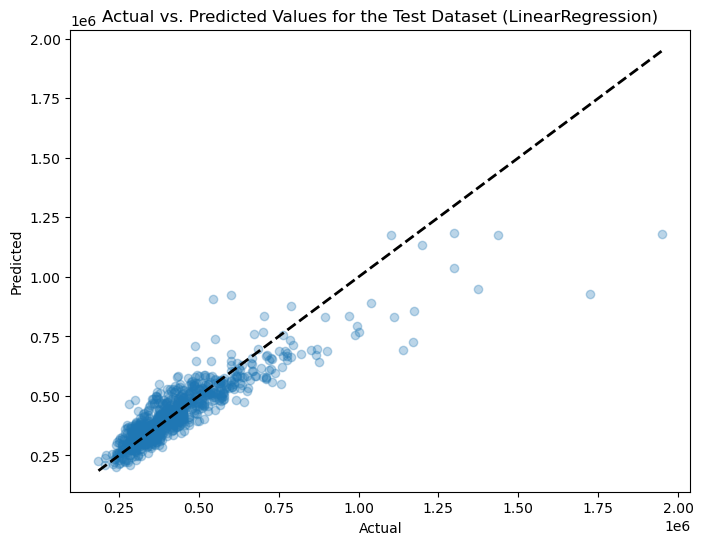

LinearRegression()

In [15]:
#Vars
model_file_name = 'LR_' + dataset_type

#Load existing model (If it exists) else train it
lr_model, lr_features, lr_training_cv_score = loadOrTrainModel(
    X_train_scaled_dummies,
    y_train,   
    X_test_scaled_dummies,
    y_test,
    model_file_name,  
    #1 = LinearRegression
    1,
    {}
)

lr_model

<div style="font-weight: bold; font-size: large; color: blue">3e. Train a elastic net regression model.</div>

<div style="font-size: medium; color: blue; font-style: italic">3ei. Refine model with complete feature set (Iteration 1).</div>

In [16]:
#Vars
model_file_name = 'EN_' + dataset_type

In [17]:
#Vars
param_grid = {
    'alpha': [0.00001, 0.0001, 0.001, 0.01],
    'l1_ratio': [0.9, 1.0],
    'max_iter': [2200, 2500, 2800],
    'tol': [0.00001, 0.0001, 0.001, 0.01]
}

#2 = ElasticNet
best_model, best_model_params, best_training_cv_score = tuneModel(X_train_scaled_dummies, y_train, X_test_scaled_dummies, y_test, model_file_name, 2, param_grid)

<div style="font-size: medium; color: blue; font-style: italic">3eii. Refine model with complete feature set (Iteration 2).</div>

In [18]:
#Vars
param_grid = {
    'alpha': [ 0.0001, 0.001, 0.01],
    'l1_ratio': [0.8, 0.9, 1.0],
    'max_iter': [2800, 3100, 3400, 3700],
    'tol': [0.0000001, 0.000001, 0.00001]
}

#2 = ElasticNet
best_model, best_model_params, best_training_cv_score = tuneModel(X_train_scaled_dummies, y_train, X_test_scaled_dummies, y_test, model_file_name, 2, param_grid)

<div style="font-size: medium; color: blue; font-style: italic">3eiii. Train model.</div>

Best features: Sq Foot, Lot Size, Bedrooms, Elementary School Ratings, Junior High School Ratings, Sex Offender Count, Walk Score, Transit Score, Downtown Distance (Meters), Avg Monthly Mortgage Rate (30Y), Pool_Inground, Pool_Community, Pool_Spa, Sex Offender Count * Walk Score, Zipcode_93307, Zipcode_93308, Zipcode_93311, Zipcode_93312, Zipcode_93313, Zipcode_93314, Zipcode_Other.

Training CV RMSE: 65500.327834678275.
Training RMSE: 65178.11310484721.
Training Adjusted R2: 0.8244801930958321.
 
Test RMSE: 79185.1079950349.
Test Adjusted R2: 0.7812456051436445.
 


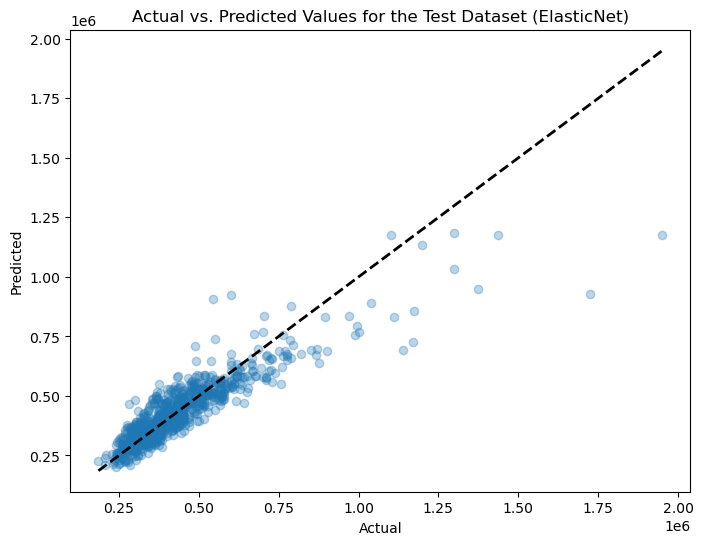

ElasticNet(alpha=0.001, l1_ratio=0.9, max_iter=3400, random_state=1, tol=1e-07)

In [19]:
#Vars
default_model_params = {
    'alpha': 0.001,
    'l1_ratio': 0.9, 
    'max_iter': 3400,
    'tol': 1e-07
}

#Load existing model (If it exists) else train it
en_model, en_features, en_training_cv_score = loadOrTrainModel(
    X_train_scaled_dummies,
    y_train,   
    X_test_scaled_dummies,
    y_test,
    model_file_name,  
    #2 = ElasticNet
    2,
    default_model_params
)

en_model

<div style="font-weight: bold; font-size: large; color: blue">3f. Train a gradient boosting model.</div>

In [20]:
#Vars
model_file_name = 'GBR_' + dataset_type

<div style="font-size: medium; color: blue; font-style: italic">3fi. Refine model with complete feature set (Iteration 1).</div>

In [21]:
#Vars
#Skipped: loss, criterion, alpha (Not applicable), validation_fraction, ccp_alpha, min_weight_fraction_leaf, max_features, ccp_alpha
param_grid = {
    'learning_rate': [0.1, 0.3, 0.5],
    'n_estimators': [80, 100, 120],  
    'subsample': [0.1, 0.5, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'max_depth': [1, 3, 5],
    'n_iter_no_change': [10, 15, 20],
    'tol': [0.000001, 0.00001, 0.0001],
    'min_impurity_decrease': [0.0001, 0.001, 0.0],
    'max_leaf_nodes': [None, 2, 8]
}

#4 = GradientBoostingRegressor
best_model, best_model_params, best_training_cv_score = tuneModel(X_train_scaled_dummies, y_train, X_test_scaled_dummies, y_test, model_file_name, 4, param_grid)

<div style="font-size: medium; color: blue; font-style: italic">3fii. Refine model with complete feature set (Iteration 2).</div>

In [22]:
#Vars
param_grid = {
    'learning_rate': [0.01],
    'n_estimators': [130, 140],  
    'subsample': [0.8, 0.9],
    'min_samples_split': [2],
    'min_samples_leaf': [4, 6, 8],
    'max_depth': [6, 8, 10],
    'n_iter_no_change': [8, 10, 12],
    'tol': [0.0000001],
    'min_impurity_decrease': [0.00001, 0.0001],
    'max_leaf_nodes': [None]
}

#4 = GradientBoostingRegressor
best_model, best_model_params, best_training_cv_score = tuneModel(X_train_scaled_dummies, y_train, X_test_scaled_dummies, y_test, model_file_name, 4, param_grid)

<div style="font-size: medium; color: blue; font-style: italic">3fiii. Train model.</div>

Best features: Sq Foot, Lot Size, Bedrooms, Elementary School Ratings, Junior High School Ratings, Sex Offender Count, Walk Score, Transit Score, Downtown Distance (Meters), Avg Monthly Mortgage Rate (30Y), Pool_Inground, Pool_Community, Pool_Spa, Sex Offender Count * Walk Score, Zipcode_93307, Zipcode_93308, Zipcode_93311, Zipcode_93312, Zipcode_93313, Zipcode_93314.

Training CV RMSE: 61424.71650927093.
Training RMSE: 48770.6873085964.
Training Adjusted R2: 0.9017462215257741.
 
Test RMSE: 91700.05934276505.
Test Adjusted R2: 0.7069901252586261.
 


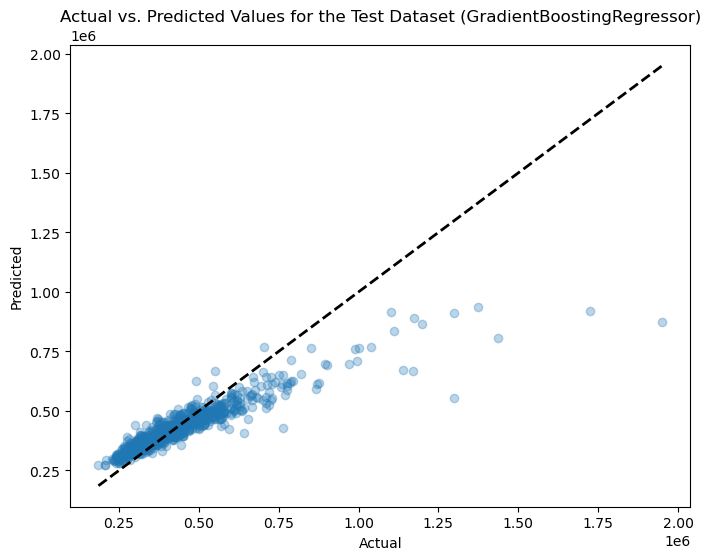

GradientBoostingRegressor(learning_rate=0.01, max_depth=10,
                          min_impurity_decrease=1e-05, min_samples_leaf=4,
                          n_estimators=140, n_iter_no_change=8, random_state=1,
                          subsample=0.8, tol=1e-07)

In [23]:
#Vars
default_model_params = {
    'learning_rate': 0.01,
    'max_depth': 10,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 1e-05,
    'min_samples_leaf': 4, 
    'min_samples_split': 2,
    'n_estimators': 140,
    'n_iter_no_change': 8,
    'subsample': 0.8,
    'tol': 1e-07
}

#Load existing model (If it exists) else train it
gbr_model, gbr_features, gbr_training_cv_score = loadOrTrainModel(
    X_train_scaled_dummies,
    y_train,   
    X_test_scaled_dummies,
    y_test,
    model_file_name,  
    #4 = GradientBoostingRegressor
    4,
    default_model_params
)

gbr_model

<div style="font-weight: bold; font-size: large; color: blue">3g. Train a random forest model.</div>

In [24]:
#Vars
model_file_name = 'RF_' + dataset_type

<div style="font-size: medium; color: blue; font-style: italic">3gi. Refine model with complete feature set (Iteration 1).</div>

In [25]:
#Vars
#Skipped: criterion, bootstrap
param_grid = {
    'n_estimators': [90, 100, 110],  
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10],
    'min_weight_fraction_leaf': [0.0, 0.3, 0.5],
    'max_leaf_nodes': [None, 2, 5],
    'min_impurity_decrease': [0.0001, 0.001, 0.0],
    'ccp_alpha': [0.0, 0.3, 0.5],
    'max_features': [0.1, 0.5, 1.0],
    'max_samples': [None, 0.5, 0.75]
}

#3 = RandomForestRegressor
best_model, best_model_params, best_training_cv_score = tuneModel(X_train_scaled_dummies, y_train, X_test_scaled_dummies, y_test, model_file_name, 3, param_grid)

<div style="font-size: medium; color: blue; font-style: italic">3gii. Refine model with complete feature set (Iteration 2).</div>

In [26]:
#Vars
param_grid = {
    'n_estimators': [10, 20, 30],  
     #'max_depth': [None, 5, 10],
    'min_samples_split': [2],
     #'min_samples_leaf': [1, 2],
     #'min_weight_fraction_leaf': [0.0, 0.3, 0.5],
     #'max_leaf_nodes': [None, 2, 5],
     #'min_impurity_decrease': [0.0001, 0.001, 0.0],
    'ccp_alpha': [0.0],
    'max_features': [0.8, 0.9, 1.0],
    'max_samples': [0.1]
}

#3 = RandomForestRegressor
best_model, best_model_params, best_training_cv_score = tuneModel(X_train_scaled_dummies, y_train, X_test_scaled_dummies, y_test, model_file_name, 3, param_grid)

<div style="font-size: medium; color: blue; font-style: italic">3giii. Train model.</div>

Best features: Sq Foot, Lot Size, Bedrooms, Elementary School Ratings, Junior High School Ratings, Sex Offender Count, Walk Score, Transit Score, Downtown Distance (Meters), Avg Monthly Mortgage Rate (30Y), Pool_Inground, Pool_Community, Pool_Spa, Sex Offender Count * Walk Score.

Training CV RMSE: 55993.66621404609.
Training RMSE: 50997.250134934104.
Training Adjusted R2: 0.8927050980587659.
 
Test RMSE: 81978.28135503946.
Test Adjusted R2: 0.7675157337652273.
 


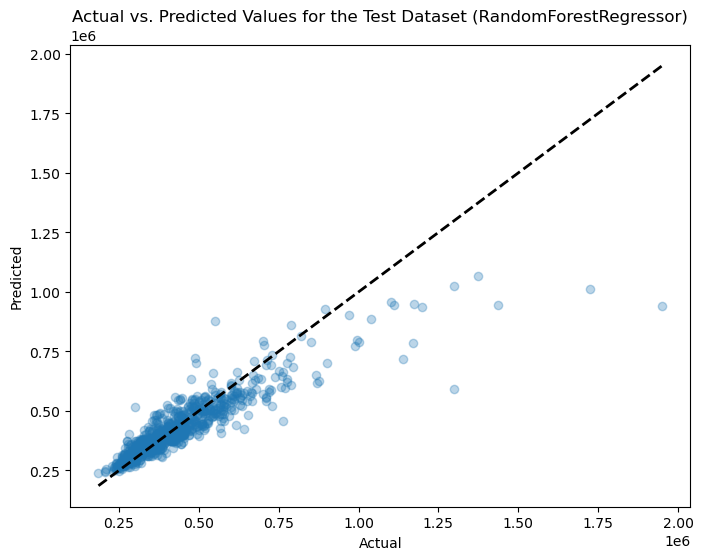

RandomForestRegressor(max_features=0.8, max_samples=0.1, n_estimators=30,
                      random_state=1)

In [27]:
#Vars
default_model_params = {
    'n_estimators': 30,
    'min_samples_split': 2,
    'ccp_alpha': 0.0,
    'max_features': 0.8,
    'max_samples': 0.1    
}

#Load existing model (If it exists) else train it
rf_model, rf_features, rf_training_cv_score = loadOrTrainModel(
    X_train_scaled_dummies,
    y_train,   
    X_test_scaled_dummies,
    y_test,
    model_file_name,  
    #3 = RandomForestRegressor
    3,
    default_model_params
)

rf_model

<div style="font-weight: bold; font-size: large; color: blue">3h. Train a neural network model.</div>

In [28]:
#Vars
model_file_name = 'NN_' + dataset_type

#Assign this variable the best features identified earlier.
nn_features = lr_features

<div style="font-size: medium; color: blue; font-style: italic">3hi. Refine model with reduced feature set (Iteration 1).</div>

In [29]:
#Vars
#Skipped: 
#activation
#solver
#batch_size
#learning_rate (Only used when solver = sgd)
#power_t (Only used when solver = sgd)
#shuffle (Only used when solver = sgd or adam)
#momentum (Only used when solver = sgd)
#nesterovs_momentum (Only used when solver = sgd)
#validation_fraction
#max_fun (Only used when solver = lbfgs)
##
##Skipped due to time constraints:
#alpha
#epsilon
param_grid = {
    'solver': ['adam'],
    #Only effective when solver = sgd or adam
    'early_stopping': [True, False],
    'hidden_layer_sizes': [
        (120, 60, 30),
        (110, 55, 27),
        (105, 52, 26),
        (90, 45, 22),
        (95, 48, 24),
        (85, 42, 21),
        (100, 50),
        (100, 50, 25, 12),
        (100, 75, 50),
        (100, 100, 50),
        (80, 60, 40),
        (125, 75, 25)
    ],
    #Only used when solver = sgd or adam
    'learning_rate_init': [0.0001, 0.001, 0.01],
    'max_iter': [200, 1000, 1500],
    'tol': [0.000001, 0.00001, 0.0001],
    'beta_1': [0.1, 0.5, 0.9],
    'beta_2': [0.1, 0.5, 0.999],
    #Only effective when solver = sgd or adam
    'n_iter_no_change': [5, 10, 15]
}

#5 = MLPRegressor
best_model, best_model_params, best_training_cv_score = tuneModel(X_train_scaled_dummies[nn_features], y_train, X_test_scaled_dummies[nn_features], y_test, model_file_name, 5, param_grid)

<div style="font-size: medium; color: blue; font-style: italic">3hii. Refine model with reduced feature set (Iteration 2).</div>

In [30]:
#Vars
param_grid = {
    'solver': ['adam'],
    #Only effective when solver = sgd or adam
    'early_stopping': [True, False],
    'hidden_layer_sizes': [
        (90, 45, 22),
        (100, 50, 25),
        (120, 60, 30),
        (150, 100, 50),
        (100, 100, 100), 
        (50, 100, 150), 
        (100, 100, 100),
        (75, 75, 75), 
        (256, 128)
    ],
    #Only used when solver = sgd or adam
    'learning_rate_init': [0.001],
    'max_iter': [1500, 2000, 2500, 3000],
    'tol': [0.0000001, 0.000001],
    'beta_1': [0.9],
    'beta_2': [0.999],
    #Only effective when solver = sgd or adam
    'n_iter_no_change': [10, 15, 20, 25]
}

#5 = MLPRegressor
best_model, best_model_params, best_training_cv_score = tuneModel(X_train_scaled_dummies[nn_features], y_train, X_test_scaled_dummies[nn_features], y_test, model_file_name, 5, param_grid)

<div style="font-size: medium; color: blue; font-style: italic">3hiii. Train model.</div>

Features: Sq Foot, Lot Size, Bedrooms, Elementary School Ratings, Junior High School Ratings, Sex Offender Count, Walk Score, Transit Score, Downtown Distance (Meters), Avg Monthly Mortgage Rate (30Y), Pool_Inground, Pool_Community, Pool_Spa, Sex Offender Count * Walk Score, Zipcode_93307, Zipcode_93308, Zipcode_93311, Zipcode_93312, Zipcode_93313, Zipcode_93314, Zipcode_Other.

Training CV RMSE: 55411.00338963103.
Training RMSE: 54715.10861712881.
Training Adjusted R2: 0.8763092859323125.
 
Test RMSE: 71106.28440025011.
Test Adjusted R2: 0.8236052190924554.
 


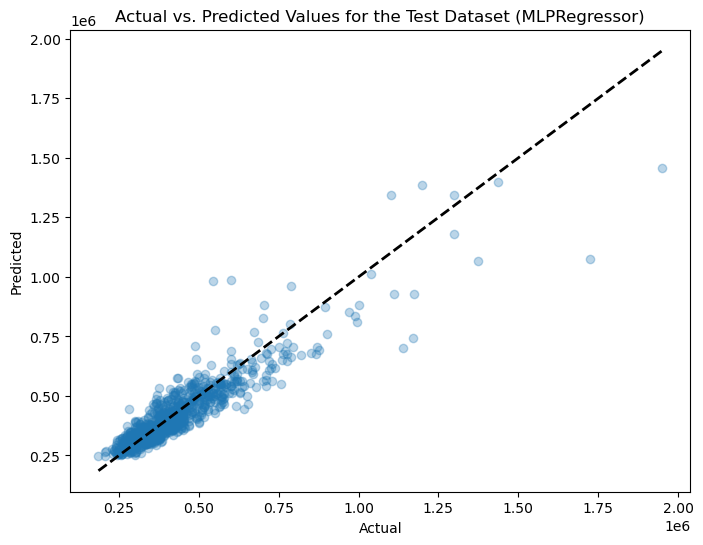

MLPRegressor(hidden_layer_sizes=(120, 60, 30), max_iter=1500, random_state=1,
             tol=1e-06)

In [31]:
#Vars
default_model_params = {
    'solver': 'adam',
    'early_stopping': False,
    'hidden_layer_sizes': (120, 60, 30),
    'learning_rate_init': 0.001,
    'max_iter': 1500,
    'tol': 1e-06,
    'beta_1': 0.9,
    'beta_2': 0.999,
    'n_iter_no_change': 10
}

#Load existing model (If it exists)
nn_model, _, nn_training_cv_score = loadModel(model_file_name)
    
#Train if null
if nn_model is None:
    #Train
    #5 = MLPRegressor
    mlp = getModel(5, default_model_params)
    
    #Perform cross-validation
    cv_scores = cross_val_score(mlp, X_train_scaled_dummies[nn_features], y_train, cv = 10, scoring = "neg_mean_squared_error", error_score = 'raise', n_jobs = -1)
    
    #Convert negative MSE to RMSE
    #neg_mean_squared_error returns negative MSE, not RMSE. That’s why we need to take the square root of the negative values to get RMSE
    cv_rmse_scores = np.sqrt(abs(cv_scores))
    nn_training_cv_score = cv_rmse_scores.mean()
    
    #Fit
    #5 = MLPRegressor
    nn_model = getModel(5, default_model_params)
    nn_model.fit(X_train_scaled_dummies[nn_features], y_train)
    
    #Save model
    saveModel(model_file_name, nn_model, nn_features, nn_training_cv_score)
        
#Evaluate
print(f"Features: {", ".join(nn_features)}.\n")
 
evalModel(X_train_scaled_dummies[nn_features], y_train, X_test_scaled_dummies[nn_features], y_test, nn_model, nn_training_cv_score)

nn_model